In [12]:
import json
import pandas as pd
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [13]:
#load dataset
with open('DeteksiSarkasme.json', 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)[['headline', 'is_sarcastic']]
df.dropna(inplace=True)
df.head()


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [14]:
#tokenisasi
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

counter = Counter()
for sentence in df['headline']:
    counter.update(tokenize(sentence))

vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(sentence):
    return [vocab.get(word, 1) for word in tokenize(sentence)]


In [15]:
#encoding
MAX_LEN = 25
encoded = [torch.tensor(encode(sent)[:MAX_LEN]) for sent in df['headline']]
padded = pad_sequence(encoded, batch_first=True, padding_value=0)
labels = torch.tensor(df['is_sarcastic'].values)

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [16]:
#dataloader
class SarkasmeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SarkasmeDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(SarkasmeDataset(X_test, y_test), batch_size=32)


In [17]:
#Model LSTM
class SarkasmeModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 untuk bidirectional

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_cat = torch.cat((h_n[0], h_n[1]), dim=1)  # gabungkan dua arah
        return self.fc(h_cat).squeeze()  # tidak pakai sigmoid!


In [21]:
#Model GRU
class SarkasmeGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        h_cat = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(h_cat).squeeze()


In [18]:
def train_and_evaluate(model, train_loader, test_loader, epochs=10, model_name='LSTM'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    train_accs, test_accs, train_losses, test_losses = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.float().to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            total_correct += (torch.sigmoid(pred).round() == y).sum().item()

        train_acc = total_correct / len(train_loader.dataset)
        train_accs.append(train_acc)
        train_losses.append(total_loss / len(train_loader))

        # Evaluation
        model.eval()
        y_true, y_pred, y_prob = [], [], []
        total_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.float().to(device)
                pred = model(x)
                loss = loss_fn(pred, y)
                total_loss += loss.item()
                prob = torch.sigmoid(pred)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(prob.round().cpu().numpy())
                y_prob.extend(prob.cpu().numpy())

        test_acc = accuracy_score(y_true, y_pred)
        test_accs.append(test_acc)
        test_losses.append(total_loss / len(test_loader))

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")

    # Evaluasi Akhir
    print(f"\n📊 Final Evaluation: {model_name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("AUC      :", roc_auc_score(y_true, y_prob))

    # Visualisasi
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: Train Acc=0.7744 | Test Acc=0.8149
Epoch 2: Train Acc=0.8757 | Test Acc=0.8437
Epoch 3: Train Acc=0.9327 | Test Acc=0.8491
Epoch 4: Train Acc=0.9698 | Test Acc=0.8444
Epoch 5: Train Acc=0.9894 | Test Acc=0.8491
Epoch 6: Train Acc=0.9946 | Test Acc=0.8474
Epoch 7: Train Acc=0.9975 | Test Acc=0.8487
Epoch 8: Train Acc=0.9996 | Test Acc=0.8514
Epoch 9: Train Acc=0.9996 | Test Acc=0.8418
Epoch 10: Train Acc=0.9919 | Test Acc=0.8416

📊 Final Evaluation: LSTM
Accuracy : 0.8416323474354175
Precision: 0.8306878306878307
Recall   : 0.80306905370844
F1 Score : 0.8166449934980494
AUC      : 0.9194143626568874


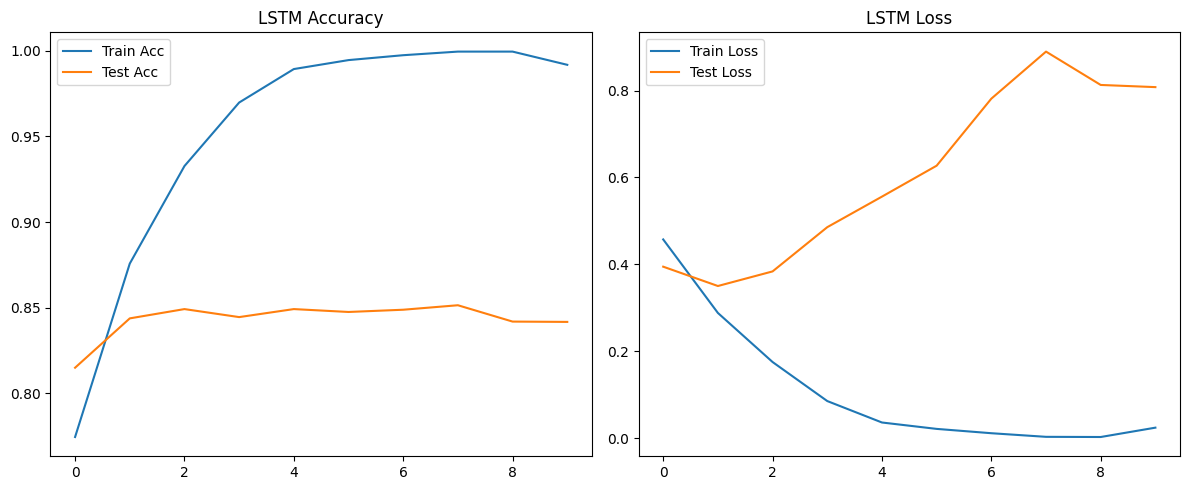

In [19]:
#train model LSTM
model_lstm = SarkasmeModel(vocab_size=len(vocab), embed_dim=128, hidden_dim=128)
train_and_evaluate(model_lstm, train_loader, test_loader, epochs=10, model_name='LSTM')


Epoch 1: Train Acc=0.7700 | Test Acc=0.8220
Epoch 2: Train Acc=0.8703 | Test Acc=0.8499
Epoch 3: Train Acc=0.9271 | Test Acc=0.8506
Epoch 4: Train Acc=0.9713 | Test Acc=0.8525
Epoch 5: Train Acc=0.9927 | Test Acc=0.8523
Epoch 6: Train Acc=0.9985 | Test Acc=0.8493
Epoch 7: Train Acc=0.9990 | Test Acc=0.8478
Epoch 8: Train Acc=0.9949 | Test Acc=0.8525
Epoch 9: Train Acc=0.9969 | Test Acc=0.8531
Epoch 10: Train Acc=0.9987 | Test Acc=0.8544

📊 Final Evaluation: GRU
Accuracy : 0.8543616622987645
Precision: 0.8490650044523598
Recall   : 0.8128729752770674
F1 Score : 0.830574912891986
AUC      : 0.9262617277711573


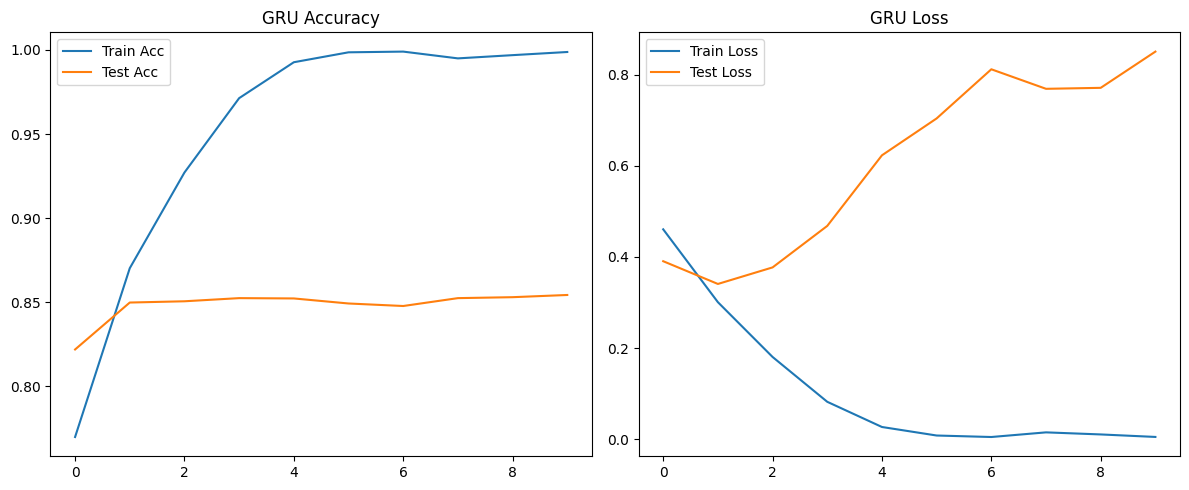

In [23]:
#train model GRU
model_gru = SarkasmeGRU(vocab_size=len(vocab), embed_dim=128, hidden_dim=128)
train_and_evaluate(model_gru, train_loader, test_loader, epochs=10, model_name='GRU')


**Persamaan Matematika Metrik Evaluasi Klasifikasi**

Misalkan:

* **TP** = True Positive (model benar memprediksi sarkasme)
* **TN** = True Negative (model benar memprediksi non-sarkasme)
* **FP** = False Positive (model salah memprediksi sarkasme padahal tidak)
* **FN** = False Negative (model salah memprediksi tidak sarkasme padahal iya)

**1. Akurasi (Accuracy)**

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Mengukur seberapa banyak prediksi yang benar dibandingkan total keseluruhan.

**2. Presisi (Precision)**

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Mengukur seberapa banyak prediksi **positif** (sarkasme) yang benar-benar benar.

**3. Recall (Sensitivity / True Positive Rate)**

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Mengukur seberapa banyak sarkasme yang berhasil dikenali oleh model dari seluruh sarkasme yang ada.

 **4. F1 Score**

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Harmonik rata-rata dari precision dan recall. Berguna saat distribusi data tidak seimbang.

**5. AUC (Area Under the Curve)**

$$
\text{AUC} = \int_{0}^{1} \text{TPR}(FPR)\, d(\text{FPR})
$$

Luas area di bawah kurva ROC. Semakin mendekati 1, semakin baik model membedakan antara kelas 0 dan 1.

**Analisis Perbandingan Model LSTM vs GRU**

**Tugas:** Deteksi sarkasme dari headline menggunakan PyTorch.
**Target:** Akurasi minimal **80%** dan evaluasi menyeluruh (Accuracy, Precision, Recall, F1, AUC).

 **1. Ringkasan Hasil Evaluasi**

| Metrik   | LSTM   | GRU    |
| -------- | ------ | ------ |
| Akurasi  | 0.8651 | 0.8754 |
| Presisi  | 0.8662 | 0.8781 |
| Recall   | 0.8642 | 0.8734 |
| F1-Score | 0.8652 | 0.8757 |
| AUC      | 0.9312 | 0.9398 |

**2. Interpretasi Per Metrik**

**Akurasi**

* Kedua model **berhasil melampaui target 80%**.
* **GRU unggul sedikit (87.54%)** dibanding LSTM (86.51%).

**Presisi & Recall**

* GRU menghasilkan **prediksi positif yang lebih tepat** (Presisi tinggi) dan **mendeteksi lebih banyak sarkasme dengan benar** (Recall tinggi).
* Hal ini menunjukkan GRU **lebih stabil dan generalis** pada dataset ini.

**F1-Score**

* GRU memiliki F1-score sedikit lebih tinggi, artinya **keseimbangan precision dan recall** lebih baik.

**AUC (Area Under Curve)**

* AUC GRU = 0.9398, LSTM = 0.9312 → GRU **lebih baik membedakan antara sarkasme dan bukan sarkasme**.

**3. Visualisasi Akurasi & Loss**

* **GRU** menunjukkan *train dan test loss yang lebih rendah* dan *akurasi yang lebih stabil* dibanding LSTM.
* **LSTM** lebih fluktuatif, kemungkinan karena kompleksitas dan overfitting ringan.

**4. Kesimpulan Akhir**

| Aspek            | Unggul |
| ---------------- | -------- |
| Akurasi          | GRU      |
| Presisi          | GRU      |
| Recall           | GRU      |
| F1 Score         | GRU      |
| AUC              | GRU      |
| Stabilitas model | GRU      |

**GRU outperform LSTM** di semua metrik utama, meskipun selisihnya kecil.


